# 思路：先对两张图像分别分类后，再用分类后得到的分类图像做差，如果结果图像中的值为0，说明没有发生变化，若不为0，则说明发生了变化。

该论文提供了数据集：https://www.mdpi.com/2072-4292/16/13/2355

使用的数据集：https://ieee-dataport.org/open-access/hrscd-high-resolution-semantic-change-detection-dataset
注：labels_land_cover_2006和labels_land_cover_2012文件夹中的文件虽然文件名相同，但是图像的像素值不相同。  
地区： The images cover a range of urban and countryside areas around the French cities of Rennes and Caen

# 数据准备

## 找到6种类型都存在的图
6种类型都存在的图：
14-2012-0460-6915-LA93-0M50-E080.tif
14-2012-0465-6915-LA93-0M50-E080.tif

In [ ]:
import os
from osgeo import gdal
import numpy as np

# 指定文件夹路径
all_dir = [r'D:\Download\HRSCD\labels_land_cover_2006\2006\D14', r'D:\Download\HRSCD\labels_land_cover_2006\2006\D35',r'D:\Download\HRSCD\labels_land_cover_2012\2012\D14', r'D:\Download\HRSCD\labels_land_cover_2012\2012\D35']
for folder_path in all_dir:
    # 遍历文件夹中的所有文件
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.tif'):  # 只处理 .tif 文件
            file_path = os.path.join(folder_path, file_name)
            
            # 打开 .tif 文件
            ds = gdal.Open(file_path)
            if ds is not None:
                band = ds.GetRasterBand(1)  # 获取第一个 band
                data = band.ReadAsArray()  # 读取数据为 numpy 数组
                
                # 输出唯一值
                unique_values = np.unique(data)
                print(f"File: {file_name}, Unique values: {unique_values}")
                
                # 释放资源
                del ds

File: 35-2012-0305-6780-LA93-0M50-E080.tif, Unique values: [0 1 2 3]
File: 35-2012-0305-6785-LA93-0M50-E080.tif, Unique values: [0 1 2 3]
File: 35-2012-0310-6780-LA93-0M50-E080.tif, Unique values: [0 1 2 3 5]
File: 35-2012-0310-6785-LA93-0M50-E080.tif, Unique values: [1 2 3 5]
File: 35-2012-0310-6790-LA93-0M50-E080.tif, Unique values: [0 1 2 3 5]
File: 35-2012-0310-6795-LA93-0M50-E080.tif, Unique values: [0 1 2 3]
File: 35-2012-0315-6765-LA93-0M50-E080.tif, Unique values: [0 1 2 3 5]
File: 35-2012-0315-6770-LA93-0M50-E080.tif, Unique values: [0 1 2 3]
File: 35-2012-0315-6775-LA93-0M50-E080.tif, Unique values: [0 1 2 3 5]
File: 35-2012-0315-6780-LA93-0M50-E080.tif, Unique values: [0 1 2 3 5]
File: 35-2012-0315-6785-LA93-0M50-E080.tif, Unique values: [1 2 3 5]
File: 35-2012-0315-6790-LA93-0M50-E080.tif, Unique values: [0 1 2 3 5]
File: 35-2012-0315-6795-LA93-0M50-E080.tif, Unique values: [1 2 3 5]
File: 35-2012-0315-6805-LA93-0M50-E080.tif, Unique values: [0 1 2 3 5]
File: 35-2012-0315-6

## 图片分块

d:\Projects\VsCode\Python\img_processing_system\.conda\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (99680256 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


[0 1 2 3 4 5]


d:\Projects\VsCode\Python\img_processing_system\.conda\Lib\site-packages\PIL\Image.py:3167: DecompressionBombWarning: Image size (99680256 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


len(image_dataset) =  1521
len(mask_dataset) =  1521
image_dataset.shape=  (1521, 256, 256, 3)
mask_dataset.shape=  (1521, 256, 256)
image_number = 226


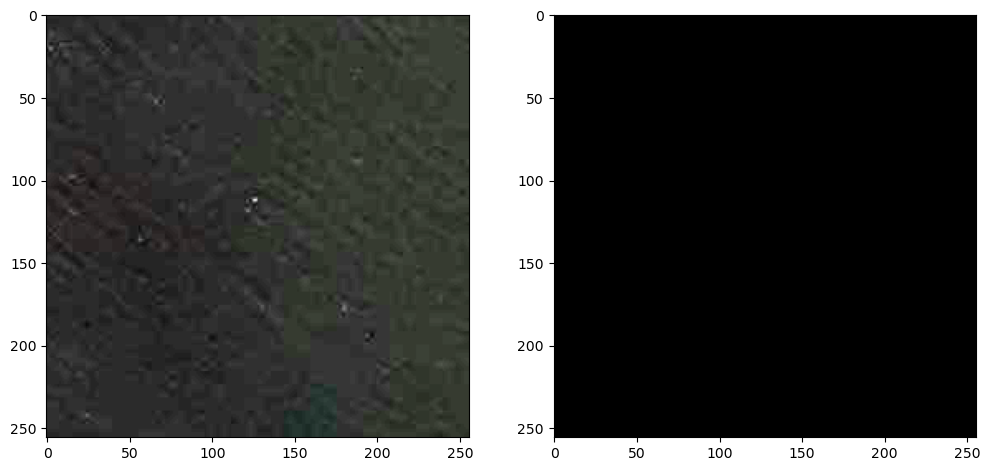

In [ ]:
import os
import cv2
import numpy as np
import torch
from matplotlib import pyplot as plt
from patchify import patchify
from PIL import Image
os.environ['SM_FRAMEWORK'] = 'tf.keras'

from sklearn.preprocessing import MinMaxScaler
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
scaler = MinMaxScaler()
root_directory = 'D:\Projects\VsCode\Python\img_processing_system\change_detection\imgs\post_classification_comparison'
os.chdir(root_directory)
patch_size = 256

# 将训练图片分成小块
image_dataset = []  
image = cv2.imread(r"images\2012\14-2012-0460-6915-LA93-0M50-E080.tif", 1) #Read each image as BGR
SIZE_X = (image.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
SIZE_Y = (image.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
image = Image.fromarray(image)
image = image.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
image = np.array(image)             

#Extract patches from each image
patches_img = patchify(image, (patch_size, patch_size, 3), step=patch_size)  #Step=256 for 256 patches means no overlap

#处理每个patch
for i in range(patches_img.shape[0]):
    for j in range(patches_img.shape[1]):
        
        single_patch_img = patches_img[i,j,:,:]
        
        #Use minmaxscaler instead of just dividing by 255. 
        single_patch_img = scaler\
            .fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1]))\
            .reshape(single_patch_img.shape)
        single_patch_img = single_patch_img[0] #Drop the extra unecessary dimension that patchify adds.                               
        image_dataset.append(single_patch_img)

# 对label图片做同样的处理
mask_dataset = []  
mask = cv2.imread(r"labels\2012\14-2012-0460-6915-LA93-0M50-E080.tif", cv2.IMREAD_UNCHANGED)  #Read each image as Grey (or color but remember to map each color to an integer)
print(np.unique(mask))
#mask = cv2.cvtColor(mask,cv2.COLOR_BGR2RGB)
SIZE_X = (mask.shape[1]//patch_size)*patch_size #Nearest size divisible by our patch size
SIZE_Y = (mask.shape[0]//patch_size)*patch_size #Nearest size divisible by our patch size
mask = Image.fromarray(mask)
mask = mask.crop((0 ,0, SIZE_X, SIZE_Y))  #Crop from top left corner
mask = np.array(mask)    

#Extract patches from each image
patches_mask = patchify(mask, (patch_size, patch_size), step=patch_size)  #Step=256 for 256 patches means no overlap
for i in range(patches_mask.shape[0]):
    for j in range(patches_mask.shape[1]):
        single_patch_mask = patches_mask[i,j,:,:]
        mask_dataset.append(single_patch_mask) 

image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)  

print("len(image_dataset) = ", len(image_dataset))
print("len(mask_dataset) = ", len(mask_dataset))
print("image_dataset.shape= ", image_dataset.shape)
print("mask_dataset.shape= ", mask_dataset.shape)


#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))  # 随机的image_number
plt.figure(figsize=(12, 6))
plt.subplot(121)
print("image_number =", image_number)
plt.imshow(np.reshape(image_dataset[image_number], (patch_size, patch_size, 3)))
plt.subplot(122)
plt.imshow(mask_dataset[image_number], cmap='gray')
plt.show()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.1, random_state = 42)


In [2]:
import segmentation_models_pytorch as smp

model = smp.Unet(
    encoder_name="resnet34",        # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",     # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,                  # model input channels (1 for gray-scale images, 3 for RGB, etc.)
    classes=6,                      # model output channels (number of classes in your dataset)
)

# move model to device
model.to(device)

# 误差函数和优化器
import torch.nn as nn
import torch.optim as optim

loss_fn = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

d:\Projects\VsCode\Python\img_processing_system\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# 训练模型

In [3]:
n_epochs = 20
batch_size = 10

for epoch in range(n_epochs):
    model.train()
    latest_loss = 0.0
    for i in range(0, len(X_train), batch_size):
        batch_X = X_train[i : i+batch_size]    # batch_X shape (N, H, W, C)
        batch_y = y_train[i : i+batch_size]    # batch_y shape (N, H, W)

        # convert to torch tensors with correct shapes/dtypes:
        # inputs.shape= (N, C, H, W), dtype= float32
        inputs = torch.tensor(batch_X, dtype=torch.float32).permute(0, 3, 1, 2).to(device)
        # targets -> (N, H, W), long (required by CrossEntropyLoss)
        targets = torch.tensor(batch_y, dtype=torch.long).to(device) # targets.shape =[10, 256, 256]
        optimizer.zero_grad()

        outputs = model(inputs)  # outputs shape: (N, num_classes, H, W) , outputs.shape= [10, 6, 256, 256]
        loss = loss_fn(outputs, targets) 
        loss.backward()
        optimizer.step()

        latest_loss = loss.item()

    print(f'Finished epoch {epoch}, latest loss {latest_loss}')

Finished epoch 0, latest loss 0.6647987365722656
Finished epoch 1, latest loss 0.6693777441978455
Finished epoch 2, latest loss 0.5464876890182495
Finished epoch 3, latest loss 0.46537113189697266
Finished epoch 4, latest loss 0.6099768280982971
Finished epoch 5, latest loss 0.4297533631324768
Finished epoch 6, latest loss 0.37045353651046753
Finished epoch 7, latest loss 0.47139209508895874
Finished epoch 8, latest loss 0.35430005192756653
Finished epoch 9, latest loss 0.33938342332839966
Finished epoch 10, latest loss 0.39957737922668457
Finished epoch 11, latest loss 0.22855977714061737
Finished epoch 12, latest loss 0.26004382967948914
Finished epoch 13, latest loss 0.24493847787380219
Finished epoch 14, latest loss 0.2216363400220871
Finished epoch 15, latest loss 0.2213098108768463
Finished epoch 16, latest loss 0.1565469205379486
Finished epoch 17, latest loss 0.1353442519903183
Finished epoch 18, latest loss 0.1347615271806717
Finished epoch 19, latest loss 0.1407954841852188


In [4]:
# 保存模型
torch.save(model, 'D:\Projects\VsCode\Python\img_processing_system\change_detection\models\post_classification_comparison.pth')
model.eval()
model.to(device)

Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

In [2]:
# 加载模型
model = torch.load('D:\Projects\VsCode\Python\img_processing_system\change_detection\models\post_classification_comparison.pth', weights_only=False)
model.eval()
model.to(device)

d:\Projects\VsCode\Python\img_processing_system\.conda\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

# 模型测试

test_img.shape=  (256, 256, 3)
input_tensor.shape = torch.Size([1, 3, 256, 256])
predicted_img unique val=  [1 2]
ground_truth unique val=  [1 2 5]


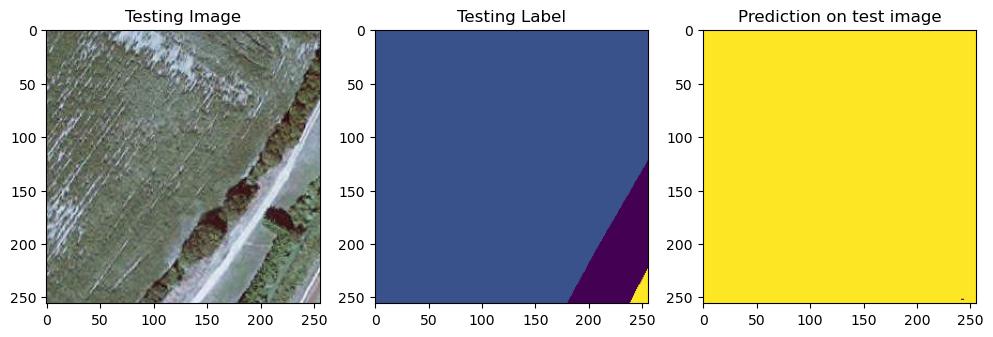

              precision    recall  f1-score   support

           1       0.00      0.00      0.00      4930
           2       0.92      1.00      0.96     60292
           5       0.00      0.00      0.00       314

    accuracy                           0.92     65536
   macro avg       0.31      0.33      0.32     65536
weighted avg       0.85      0.92      0.88     65536



d:\Projects\VsCode\Python\img_processing_system\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Projects\VsCode\Python\img_processing_system\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
d:\Projects\VsCode\Python\img_processing_system\.conda\Lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(ave

In [12]:
#Predict on a few images
import random
test_img_number = random.randint(0, len(X_test))
test_img = X_test[test_img_number]

ground_truth = y_test[test_img_number]

# 如何把test_img交给模型来预测？
# 答：给test_img增加一个维度，然后调换维度的顺序
print("test_img.shape= ", test_img.shape) # test_img.shape=  (256, 256, 3)

# prepare input tensor: from (H, W, C) --> (1, C, H, W)
input_tensor = torch.tensor(test_img, dtype=torch.float32).permute(2, 0, 1).unsqueeze(0).to(device)
print("input_tensor.shape =", input_tensor.shape)  # input_tensor.shape = (1, 3, 256, 256)

# run inference (no .predict for PyTorch modules)
model.eval()
with torch.no_grad():
	outputs = model(input_tensor)  # outputs.shape: (1, num_classes, H, W), 元素的取值：小数
	# convert logits to per-pixel class labels [0..5]
	predicted_img = outputs.argmax(dim=1).squeeze(0).cpu().numpy().astype(np.uint8) 

print("predicted_img unique val= ", np.unique(predicted_img))
print("ground_truth unique val= ", np.unique(ground_truth))

plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img)
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground_truth)
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(predicted_img)
plt.show()

from sklearn.metrics import classification_report
print(classification_report(ground_truth.flatten(), predicted_img.flatten()))

## 对输入的图片中数据量较大的类预测比较准，但是如果某些类明显小于其他类，那么预测效果很差。

# 评估模型

In [5]:
outputs = model(torch.tensor(X_test, dtype=torch.float32).permute(0, 3, 1, 2).to(device)) #outputs.shape= [261, 6, 256, 256]
final_outputs = outputs.argmax(dim=1).squeeze().cpu()

In [6]:
from keras.metrics import MeanIoU
miou = MeanIoU(num_classes=6)
miou.update_state(torch.tensor(y_test), final_outputs)
print("Mean IOU = ", miou.result().numpy())

Mean IOU =  0.5150874


## 模型表现：n_epochs = 20，Mean IOU =  0.5150874

# 对未见过的图像进行分类

In [ ]:
# 由于模型精度不是很好，就没有使用模型对未见过的图片进行预测了，直接用已分类的图片进行后续的比较。

# 比较


In [ ]:
import numpy as np
from osgeo import gdal
# 假装下面两张图片是模型的预测结果
ds_2012 = gdal.Open(r'D:\Download\HRSCD\labels_land_cover_2012\2012\D14\14-2012-0435-6910-LA93-0M50-E080.tif') 
ds_2006 = gdal.Open(r'D:\Download\HRSCD\labels_land_cover_2006\2006\D14\14-2012-0435-6910-LA93-0M50-E080.tif')
band_2012 = ds_2012.GetRasterBand(1)
land_cover_2012 = band_2012.ReadAsArray()

band_2006 = ds_2006.GetRasterBand(1)
land_cover_2006 = band_2006.ReadAsArray()

diff = land_cover_2012.astype(np.int8) - land_cover_2006.astype(np.int8)
print(np.unique(diff))
del ds_2012, ds_2006

## 量化land cover变化情况

In [ ]:
from sklearn.metrics import confusion_matrix
y_true = land_cover_2006.ravel()
y_pred = land_cover_2012.ravel()

# 混淆矩阵可表示land cover的变化情况，
# 例如：以下混淆矩阵第一行表示有115444个像素由2006年的Artificial surfaces变成了2012年的Agricultural areas
labels = np.unique(np.concatenate([y_true, y_pred]))
cm = confusion_matrix(y_true, y_pred, labels=labels)

print("Labels:", labels)
print("Change Matrix:\n", )
print(cm)
